# Train the Mask Detector Model

In [1]:
!python --version
!ls

Python 3.6.10 :: Anaconda, Inc.


README.md
detect_mask_on_face.ipynb
detect_mask_on_video.ipynb
detect_video.py
mtcnn_vid.py
remove_images_from_dataset.py
saved_model
self-built-masked-face-recognition-dataset
self-built-masked-face-recognition-dataset.zip
test_images
train_mask_detection_model.ipynb


In [1]:
from glob import glob
from pathlib import Path
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.models import save_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer



In [2]:
''' Initiate the main parameters of the training '''

BASE_LEARNING_RATE = 0.0001
EPOCHS = 2
BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_OF_CLASSES = 2

In [3]:

def list_image_paths(dataset_dir):
    '''
        :param:dataset_dir -> Path of the directory that contains the dataset 
        
        Returns a list of all the image file paths inside the given directory
         
    '''
    
    print("___[Listing Image Paths]___") 
    # Search for different file extensions, and concatenate the results 
    image_extensions = ['**/*.jpg', '**/*.png']
    image_paths = glob(os.path.join(dataset_dir, image_extensions[0]), recursive = True) + glob(os.path.join(dataset_dir, image_extensions[1]), recursive = True)
    print('\nNumber of images: {}'.format(len(image_paths)))
    return image_paths

In [4]:
dataset_dir= 'self-built-masked-face-recognition-dataset/'
image_paths = list_image_paths(dataset_dir)

___[Listing Image Paths]___

Number of images: 4383


In [5]:
def load_images_and_labels(image_paths):
    '''
        Input  : image paths
        Output : image_data and class labels 
        
        For each image path, extracts the image label from class directory name
        Then returns image data and labels 
    '''
    
    print('___[Loading Images and Their Labels]___')
    image_data = []
    labels = []
    
    for image_path in image_paths:
        
        # Get the labels of the images from directory name
        label = os.path.split(image_path)[0].split("\\")[-2]
        labels.append(label)

        # Load the images from the paths
        image = load_img(image_path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = img_to_array(image)
        image = preprocess_input(image)
        image_data.append(image)
        
    # Convert image_data and labels from list to numpy array
    image_data = np.array(image_data)
    labels = np.array(labels)

    print('\nImage data : {}\nLabels : {}'.format(image_data.shape, labels.shape))
        
    return image_data,labels


In [6]:
# Load the image data and labels to variables 
# With a large enough dataset RAM easily fills up, so looking for alternative methods 
# that could help might be a good idea
image_data, labels = load_images_and_labels(image_paths)

___[Loading Images and Their Labels]___

Image data : (4383, 224, 224, 3)
Labels : (4383,)


In [7]:
''' Convert the image data and th labels to numpy array '''

image_data = np.array(image_data)
labels = np.array(labels)

In [8]:
''' Prepare labels for training '''
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Performing One-hot-encoding on the labels, transforms categorical features 
# to a format that works better with classification 
labels = to_categorical(labels)
labels.shape

# print(labels)

(4383, 2)

In [9]:
# Stratify parameter makes sure the train_test_split method returns training and test subsets 
# that have the same proportions of class labels as the input dataset.
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.25, stratify=labels, random_state=42)
print('Training data : {}, Training labels : {}'.format(X_train.shape, y_train.shape))
print('Testing data : {}, Testing labels : {}'.format(X_test.shape, y_test.shape))

Training data : (3287, 224, 224, 3), Training labels : (3287, 2)
Testing data : (1096, 224, 224, 3), Testing labels : (1096, 2)


In [10]:
''' Data augmentation '''

# The dataset is not just consists of "ideal front-facing face images"   
# But in order to train the model to be more accurate, it's a good idea to use data augmentation

data_aug = ImageDataGenerator(rotation_range = 20,
                             zoom_range = 0.1,
                             width_shift_range = 0.15,
                             height_shift_range = 0.15,
                             shear_range = 0.15,
                             horizontal_flip = True)

In [11]:
''' Create the base model from the pre-trained model MobileNet V2, by following the tensorflow documentation '''

base_model = MobileNetV2(input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),
                         include_top = False,
                         weights = 'imagenet')

In [12]:
print(base_model.output)
print(base_model.input)

Tensor("out_relu/Identity:0", shape=(None, 7, 7, 1280), dtype=float32)
Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)


In [13]:
''' Create new top layers --> according to our classification purpose '''

head_model = base_model.output
head_model = layers.AveragePooling2D(pool_size=(5,5))(head_model)
head_model = layers.Flatten()(head_model)
head_model = layers.Dense(128, activation='relu')(head_model)
head_model = layers.Dropout(0.5)(head_model)
head_model = layers.Dense(NUM_OF_CLASSES, activation='softmax')(head_model)

# We will freeze the weights of the base model, so on the training,
# only the weights of the classification model(head model) will be updated 

# In order to "fine tune" our model, we may open some of the layers of the base model to training,
# this can really help improving the quality of our model 
base_model.trainable = False

In [14]:
''' Connect the base and the head models by using keras.Model
    We could also have been used Sequential model as we did in our labs
'''
# With the "functional API", where you start from Input, you chain layer calls to specify the model's forward pass,
# and finally you create your model from inputs and outputs

# keras.Model is described as above, 
# in our case base_model will be our inputs and head_model will be the output

model = Model(inputs = base_model.input, outputs = head_model)


In [15]:
''' Configure and compile the model '''
optimizer = Adam(learning_rate = BASE_LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [17]:
''' Train the model '''

# Flow method takes data & label arrays, generates batches of augmented data.

history = model.fit(data_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS)

Epoch 1/2
102/102 [==============================] - 101s 990ms/step - loss: 0.2793 - accuracy: 0.8857 - val_loss: 0.0803 - val_accuracy: 0.9799
Epoch 2/2
102/102 [==============================] - 92s 900ms/step - loss: 0.0852 - accuracy: 0.9702 - val_loss: 0.0558 - val_accuracy: 0.9836


In [18]:
''' A quick peek of our model`s performance '''
predict = model.predict(X_test, batch_size=BATCH_SIZE)
predict = np.argmax(predict, axis=1)

print(classification_report(y_test.argmax(axis=1), predict,
                    target_names=lb.classes_))

                          precision    recall  f1-score   support

       AFDB_face_dataset       0.99      0.98      0.98       550
AFDB_masked_face_dataset       0.98      0.99      0.98       546

                accuracy                           0.98      1096
               macro avg       0.98      0.98      0.98      1096
            weighted avg       0.98      0.98      0.98      1096



In [20]:
''' Save the trained model to use later '''
model.save('./saved_model/new_model.h5')

In [32]:
''' Plot training and validation accuracies and losses '''

def plot_history(history):
    plt.figure(figsize=(16,7))
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], color='red')
    plt.plot(history.history['val_accuracy'], color='blue')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(16,7))
    # Plot training & validation loss values
    plt.plot(history.history['loss'], color='red')
    plt.plot(history.history['val_loss'], color='blue')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid()
    plt.show()

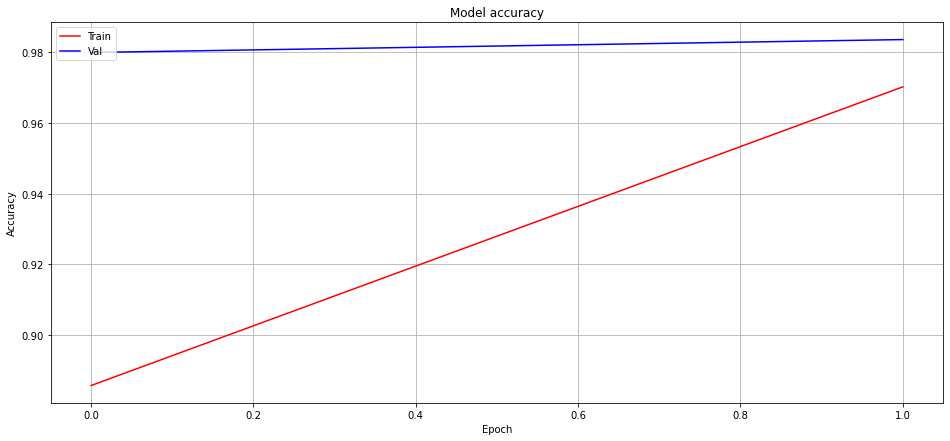

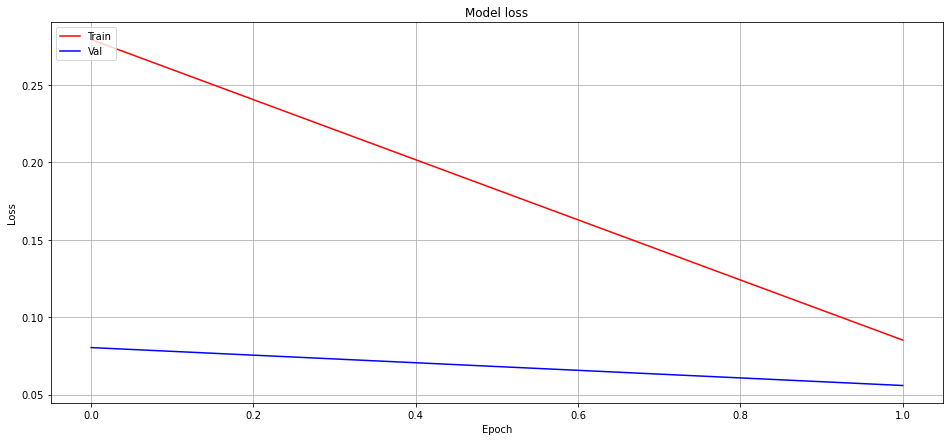

In [33]:
plot_history(history)